<a href="https://colab.research.google.com/github/ton-david/NCAA-Baseball-Analytics/blob/main/Wagner_Baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This project webscrapes data from https://wagnerathletics.com/sports/baseball/stats/2019 for exploratory data analysis and supervised machine learning
# - Purpose: Analyze Wagner College Baseball-2019 data for patterns and correlations
#            Provide team with in-depth insights to increase probability of winning
#            Use predictive analytics to forecast team's performance
# - Machine Learning models: Linear Regression, Logistic Regression
# - Data: Batting & pitching statistics from all 51 games of the 2019 season
# Sections:
# 1. Predicting Runs Allowed from Hits given up (Linear Regression Model)
# 2. Predicting Runs Scored from Hits (Linear Regression Model)
# 3. Win Percentage vs. Strikeouts per Game
# 4. Probability of Winning based on Number of Hits (Logistic Regression Model)
# 5. Probability of Winning if there is >= 1 Homerun (Logistic Regression Model)

In [ ]:
import pandas as pd
import numpy as np
import requests as r
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
# Read in 2019 Team Statistics
df2019 = pd.read_html('https://wagnerathletics.com/sports/baseball/stats/2019')

# **Pitching Statistics**

###Cleaning Data

In [ ]:
# Pitching Statistics per Game
pitching_stats = df2019[7]
pitching_stats.replace(['at','vs'],'Away', inplace = True)
pitching_stats.fillna('Home', inplace = True)
pitching_stats = pitching_stats.rename(columns = {'Loc':'Location','Score.1':'Score'})
pitching_stats['W/L'] = pitching_stats['W/L'].replace({"W": 1, "L": 0})
pitching_stats.drop(index = pitching_stats.index[-1], axis = 0, inplace = True) # Dropping last row (aggregation row)
pitching_stats['W/L'] = pitching_stats['W/L'].astype('int64')
pitching_stats['Date'] = pd.to_datetime(pitching_stats['Date'], format='%m/%d/%Y')
pitching_stats.head()

,Date,Location,Opponent,W/L,Score,IP,H,R,ER,BB,...,HR,WP,BK,HBP,IBB,Score,W,L,SV,ERA
0,2019-02-15,Away,San Diego,0,0-14,8.0,16,14,11,8,...,0,5,0,3,0,0-14,0,1,0,12.38
1,2019-02-16,Away,San Diego,0,1-3,8.0,8,3,3,4,...,1,1,0,1,1,1-3,0,2,0,3.38
2,2019-02-16,Away,San Diego,0,9-15,8.0,15,15,11,5,...,1,0,1,3,0,9-15,0,3,0,12.38
3,2019-02-23,Away,ETSU,0,1-6,8.0,9,6,6,6,...,1,3,0,4,1,1-6,0,4,0,6.75
4,2019-02-24,Away,ETSU,0,3-4,6.0,6,4,3,7,...,1,0,0,1,0,3-4,0,5,0,4.5


In [ ]:
# Pairwise correlations/linear relationship between 2 pitching statistics
pitching_stats.corr().round(3)

,W/L,IP,H,R,ER,BB,SO,2B,3B,HR,WP,BK,HBP,IBB,W,L,SV
W/L,1.000,0.501,-0.466,-0.550,-0.551,-0.177,0.182,-0.105,-0.074,-0.249,-0.185,0.228,-0.190,-0.277,0.160,0.120,0.681
IP,0.501,1.000,-0.354,-0.335,-0.391,-0.076,0.235,-0.211,0.085,-0.344,0.027,0.288,-0.240,0.052,0.420,0.382,0.268
H,-0.466,-0.354,1.000,0.770,0.753,0.228,-0.204,0.335,0.170,0.267,0.022,0.062,0.203,0.007,-0.261,-0.211,-0.306
R,-0.550,-0.335,0.770,1.000,0.911,0.498,-0.266,0.405,0.196,0.169,0.170,0.031,0.441,-0.026,-0.390,-0.344,-0.350
ER,-0.551,-0.391,0.753,0.911,1.000,0.472,-0.206,0.432,0.241,0.300,0.148,-0.007,0.372,0.034,-0.388,-0.332,-0.359
BB,-0.177,-0.076,0.228,0.498,0.472,1.000,-0.215,0.290,0.270,-0.252,0.151,0.016,0.188,0.075,-0.337,-0.291,0.177
SO,0.182,0.235,-0.204,-0.266,-0.206,-0.215,1.000,-0.203,-0.022,0.115,-0.082,0.050,-0.139,0.118,0.153,0.198,0.070
2B,-0.105,-0.211,0.335,0.405,0.432,0.290,-0.203,1.000,-0.076,0.121,-0.009,-0.021,0.099,-0.159,-0.191,-0.145,-0.096
3B,-0.074,0.085,0.170,0.196,0.241,0.270,-0.022,-0.076,1.000,-0.286,0.038,0.223,0.177,0.257,-0.000,-0.005,-0.139
HR,-0.249,-0.344,0.267,0.169,0.300,-0.252,0.115,0.121,-0.286,1.000,-0.275,-0.117,-0.069,-0.094,-0.057,-0.054,-0.309


### **1. Predicting Runs Allowed from Hits (Linear Regression Model)**

In [ ]:
# Correlation between Runs Allowed and Hits
print('Correlation Coefficient (R): ', pitching_stats['R'].corr(pitching_stats['H']))

Correlation Coefficient (R):  0.7704594021722708


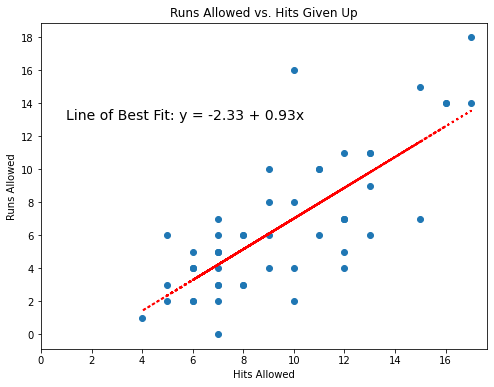

In [ ]:
# Scatter Plot
x = pitching_stats['H']
y = pitching_stats['R']
plt.figure(figsize=(8,6))
plt.scatter(x,y)
plt.xlim(0, None)
plt.xticks(range(0,18,2))
plt.yticks(range(0,20,2))
plt.xlabel("Hits Allowed")
plt.ylabel("Runs Allowed")
plt.title("Runs Allowed vs. Hits Given Up")
c, d = np.polyfit(x, y, 1) #find line of best fit
plt.plot(x, c*x+d, color='red', linestyle='dotted', linewidth=2) #add line of best fit to plot
plt.text(1, 13, 'Line of Best Fit: y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=14) #add fitted regression equation to plot
plt.show()

####**Linear Regression Model**

In [ ]:
from pandas.core.common import random_state
x = pitching_stats['H'].values.reshape(-1,1)
y = pitching_stats['R'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)
print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 38
Testing Data Count: 13


In [ ]:
# Train Model
linreg = LinearRegression() #create linear regression model
linreg.fit(X_train, y_train) #training regression model
linreg_int = str(linreg.intercept_).replace('[', '').replace(']', '') # convert np array to string
linreg_coef = str(linreg.coef_).replace(' [', '').replace('[', '').replace(']', '').replace('] ','')
print('Linear Regression Model Intercept: ', linreg_int)
print('Linear Regression Model Slope: ', linreg_coef)

Linear Regression Model Intercept:  -1.10153466
Linear Regression Model Slope:  0.80413121


In [ ]:
# Test Model
lin_pred = linreg.predict(X_test)

    Actual  Predicted  Residual
0        5   4.527384  0.472616
1        2   2.919121 -0.919121
2       18  12.568696  5.431304
3       10   7.743909  2.256091
4       15  10.960433  4.039567
5       14  11.764565  2.235435
6        2   6.939777 -4.939777
7        4   4.527384 -0.527384
8        4   6.939777 -2.939777
9        4   3.723253  0.276747
10       9   9.352171 -0.352171
11       5   8.548040 -3.548040
12       1   2.114990 -1.114990


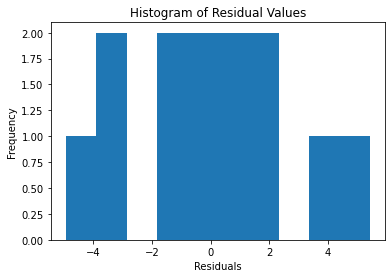

In [ ]:
# Compare actual and predicted values for X_test
compare_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': lin_pred.flatten()})
compare_df['Residual'] = compare_df['Actual'] - compare_df['Predicted']
print(compare_df)
plt.hist(compare_df['Residual']) # histogram of residuals
plt.title("Histogram of Residual Values")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

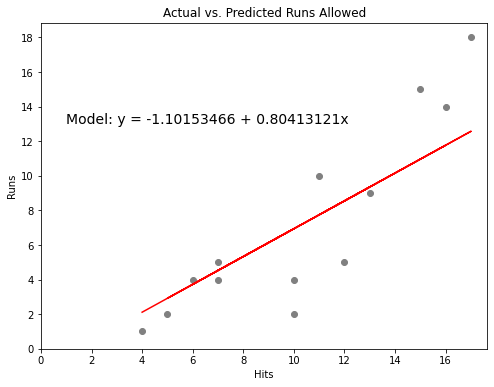

In [ ]:
# Plotting predicted values on top of actual values
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color = 'gray') # Actual Values
plt.plot(X_test, lin_pred, color = 'red') # Predicted values
plt.xticks(range(0,18,2))
plt.yticks(range(0,20,2))
plt.xlabel("Hits")
plt.ylabel("Runs")
plt.title("Actual vs. Predicted Runs Allowed")
plt.text(1, 13, 'Model: y = ' + linreg_int + ' + ' + linreg_coef + 'x', size=14)
plt.show()

In [ ]:
# Evaluating Performance of Model
print('Coefficient of Determination (R^2):', r2_score(y_test, lin_pred))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, lin_pred))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, lin_pred))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, lin_pred)))

Coefficient of Determination (R^2): 0.7162664034036852
Mean Absolute Error:  2.2348478490743378
Mean Squared Error:  8.025127761718254
Root Mean Squared Error:  2.8328656448406186


**User Input: Predict runs allowed using model (run cell below)**

In [ ]:
hits_allowed = float(input('Enter number of hits allowed: '))
runs_allowed = linreg.coef_ * hits_allowed + linreg.intercept_
print('Predicted runs allowed: ', str(runs_allowed).replace(' [', '').replace('[', '').replace(']', '').replace('] ',''))

Enter number of hits allowed: 9
Predicted runs allowed:  6.13564623


# **Batting Statistics**

###Cleaning Data

In [ ]:
# Batting Statistics per Game
batting_stats = df2019[6]
batting_stats.replace(['at','vs'],'Away', inplace = True)
batting_stats.fillna('Home', inplace = True)
batting_stats.replace('home','Home', inplace = True)
batting_stats.replace('away','Away', inplace = True)
batting_stats = batting_stats.rename(columns = {'Loc':'Location'})
batting_stats['W/L'].replace({"W": 1, "L": 0}, inplace = True)
batting_stats.drop(index = batting_stats.index[-1], axis = 0, inplace = True) # Dropping last row (aggregation row)
batting_stats['W/L'] = batting_stats['W/L'].astype('int64')
batting_stats['Date'] = pd.to_datetime(batting_stats['Date'], format='%m/%d/%Y')
batting_stats.head()

,Date,Location,Opponent,W/L,Score,AB,R,H,RBI,2B,...,CS,HBP,SH,SF,GDP,K,PO,A,E,AVG
0,2019-02-15,Away,San Diego,0,0-14,27,0,1,0,1,...,1,0,0,0,0,12,24,10,2,0.037
1,2019-02-16,Away,San Diego,0,1-3,33,1,7,1,1,...,0,0,0,0,0,10,24,11,0,0.212
2,2019-02-16,Away,San Diego,0,9-15,35,9,14,9,0,...,0,0,1,3,0,4,24,7,3,0.4
3,2019-02-23,Away,ETSU,0,1-6,28,1,2,1,0,...,0,1,0,0,1,8,24,10,0,0.071
4,2019-02-24,Away,ETSU,0,3-4,26,3,6,3,1,...,1,2,1,0,0,11,18,2,1,0.231


In [ ]:
# Pairwise correlations/linear relationship between 2 batting statistics
batting_stats.corr().round(4)

### **2. Predicting Runs Scored from Hits (Linear Regression Model)**

In [ ]:
runs_hits = batting_stats[['H','R']]
runs_hits = runs_hits.rename(columns={runs_hits.columns[0]:'hits', runs_hits.columns[1]:'runs'})
# Correlation between Runs Scored and Hits
print('Correlation Coefficient (R): ', runs_hits['runs'].corr(runs_hits['hits']))

Correlation Coefficient (R):  0.8519450042677918


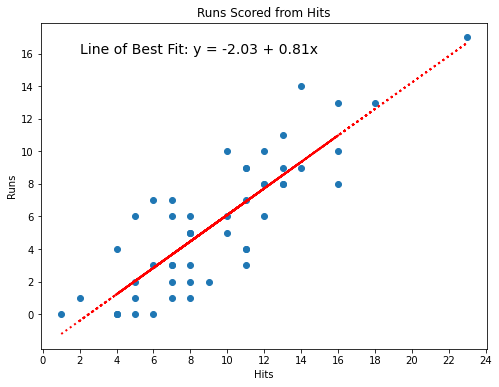

In [ ]:
# Scatter Plot
x = runs_hits['hits']
y = runs_hits['runs']
plt.figure(figsize=(8, 6))
plt.scatter(x=runs_hits['hits'], y=runs_hits['runs'])
plt.xticks(range(0,25,2))
plt.yticks(range(0,18,2))
plt.xlabel("Hits")
plt.ylabel("Runs")
plt.title("Runs Scored from Hits")
a, b = np.polyfit(x, y, 1) #find line of best fit
plt.plot(x, a*x+b, color='red', linestyle='dotted', linewidth=2) #add line of best fit to plot
plt.text(2, 16, 'Line of Best Fit: y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14) #add fitted regression equation to plot
plt.show()

####**Linear Regression Model**

In [ ]:
from pandas.core.common import random_state
x = runs_hits['hits'].values.reshape(-1,1)
y = runs_hits['runs'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 40
Testing Data Count: 11


In [ ]:
# Train Model
model = LinearRegression() #create linear regression model
model.fit(X_train, y_train) #training regression model
model_int = str(model.intercept_).replace('[', '').replace(']', '') # convert np array to string
model_coef = str(model.coef_).replace(' [', '').replace('[', '').replace(']', '').replace('] ','')
print('Linear Regression Model Intercept: ', model_int)
print('Linear Regression Model Slope: ', model_coef)

Linear Regression Model Intercept:  -2.0893023
Linear Regression Model Slope:  0.83077711


In [ ]:
# Test Model: Using model to make predictions
prediction = model.predict(X_test)

In [ ]:
# Compare prediction values to actual values for X_test
compare_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted':prediction.flatten()})
print(compare_df)

# histogram of residuals (difference between actual and predicted value)
plt.hist(y_test - prediction)
plt.title("Histogram of Residual Values") 
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Plotting linear regression model on top of actual values
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color = 'gray') # Actual Values
plt.plot(X_test, prediction, color = 'red') # Predicted values
plt.xticks(range(0,19,2))
plt.yticks(range(0,13,2))
plt.xlabel("Hits")
plt.ylabel("Runs")
plt.title("Actual vs. Predicted Runs Scored")
plt.text(1.5, 10.75, 'Model: y = ' + model_int + ' + ' + model_coef + 'x', size=14)
plt.show()

In [ ]:
# Evaluating Performance of Model
print('Coefficient of Determination (R^2):', r2_score(y_test, prediction))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, prediction))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, prediction))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

Coefficient of Determination (R^2): 0.6543095230074105
Mean Absolute Error:  1.382102863995855
Mean Squared Error:  3.456904769925895
Root Mean Squared Error:  1.8592753346198876


**User Input: Predict runs scored using model (run cell below)**

In [ ]:
# Predict runs scored using model
hits = float(input('Enter number of hits: '))
runs_scored = model.coef_ * hits + model.intercept_
print('Predicted runs scored: ', str(runs_scored).replace(' [', '').replace('[', '').replace(']', '').replace('] ',''))

### **3. Win Percentage vs. Strikeouts per Game**

In [ ]:
# Grouping games by number of strikeouts
low_k = batting_stats[batting_stats['K'].between(0,4)]
med_k = batting_stats[batting_stats['K'].between(5,9)]
high_k = batting_stats[batting_stats['K'].between(10,14)]
low_k

,Date,Location,Opponent,W/L,Score,AB,R,H,RBI,2B,...,CS,HBP,SH,SF,GDP,K,PO,A,E,AVG
2,2019-02-16,Away,San Diego,0,9-15,35,9,14,9,0,...,0,0,1,3,0,4,24,7,3,0.4
12,2019-03-15,Home,MOUNT ST. MARY'S,0,5-6,35,5,10,5,1,...,1,0,0,1,0,4,27,7,0,0.286
13,2019-03-16,Home,MOUNT ST. MARY'S,1,9-8,32,9,11,9,3,...,0,1,0,2,1,4,27,9,4,0.344
16,2019-03-20,Home,SAINT PETER'S,1,13-3,42,13,18,13,3,...,0,0,0,0,0,3,27,11,3,0.429
17,2019-03-23,Away,Monmouth,1,13-4,42,13,16,12,5,...,1,1,0,2,0,4,27,5,0,0.381
21,2019-03-30,Away,Central Connecticut,1,4-2,31,4,4,2,1,...,1,1,0,0,1,3,27,14,1,0.129
22,2019-03-31,Away,Central Connecticut,0,3-10,36,3,11,3,3,...,1,0,0,0,0,3,24,8,1,0.306
26,2019-04-07,Away,Sacred Heart,1,5-4,36,5,8,4,1,...,0,1,0,0,0,3,27,15,0,0.222
27,2019-04-10,Home,RIDER,1,9-1,37,9,13,8,0,...,1,1,1,0,0,4,27,7,1,0.351
38,2019-04-28,Home,BRYANT,0,2-3,33,2,7,1,2,...,0,0,0,0,2,4,27,10,1,0.212


In [ ]:
# Get winning percentage based on number of strikeouts
low_k_perc = pd.DataFrame((low_k['W/L'].value_counts(normalize = True)))
med_k_perc = pd.DataFrame((med_k['W/L'].value_counts(normalize = True)))
high_k_perc = pd.DataFrame((high_k['W/L'].value_counts(normalize = True)))

# Combining winning percentages for visualization
k_win_perc = pd.concat([low_k_perc, med_k_perc, high_k_perc], axis = 1, ignore_index=True)
k_win_perc = k_win_perc.rename(columns={k_win_perc.columns[0]:'0-4 K',k_win_perc.columns[1]:'5-9 K', k_win_perc.columns[2]:'10-14 K'},index = {0:'Loss',1:'Win'})
k_win_perc

,0-4 K,5-9 K,10-14 K
Loss,0.333333,0.709677,0.75
Win,0.666667,0.290323,0.25


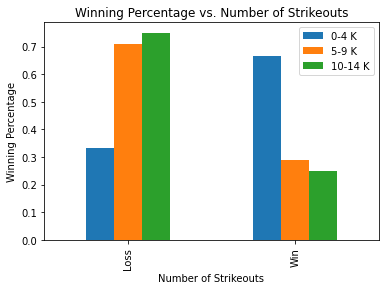

In [ ]:
k_win_perc.plot(kind='bar')          
plt.title('Winning Percentage vs. Number of Strikeouts')
plt.xlabel('Number of Strikeouts')
plt.ylabel('Winning Percentage')
plt.show()

### **4. Probability of Winning based on Number of Hits (Logistic Regression Model)**

In [ ]:
win_count = pd.DataFrame(batting_stats[batting_stats['W/L'] == 1].groupby('H')['W/L'].count()) # Number of wins per hit count
hit_game_count = pd.DataFrame(batting_stats.groupby('H')['W/L'].count()) # Count of number of games by number of hits

# Joining win_count and hit_game_count to find winning percentage per number of hits
hit_win_perc = hit_game_count.merge(win_count, on= 'H', how='left')

,W/L_x,W/L_y
H,,
1,1,NaN
2,1,NaN
4,4,1.0
5,4,NaN
6,3,NaN
7,6,2.0
8,7,3.0
9,1,NaN
10,3,NaN


In [ ]:
hit_win_perc = hit_win_perc.rename(columns={hit_win_perc.columns[0]:'total_games', hit_win_perc.columns[1]:'wins'})
hit_win_perc['wins'] = hit_win_perc['wins'].fillna(0)
hit_win_perc['win_percentage'] = (hit_win_perc['wins']/hit_win_perc['total_games']).round(3) * 100

In [ ]:
hit_win_perc = hit_win_perc.reset_index()
hit_win_perc = hit_win_perc.rename(columns={hit_win_perc.columns[0]:'hits'})
print(hit_win_perc)

    hits  total_games  wins  win_percentage
0      1            1   0.0             0.0
1      2            1   0.0             0.0
2      4            4   1.0            25.0
3      5            4   0.0             0.0
4      6            3   0.0             0.0
5      7            6   2.0            33.3
6      8            7   3.0            42.9
7      9            1   0.0             0.0
8     10            3   0.0             0.0
9     11            6   3.0            50.0
10    12            4   1.0            25.0
11    13            4   4.0           100.0
12    14            2   1.0            50.0
13    16            3   2.0            66.7
14    18            1   1.0           100.0
15    23            1   1.0           100.0


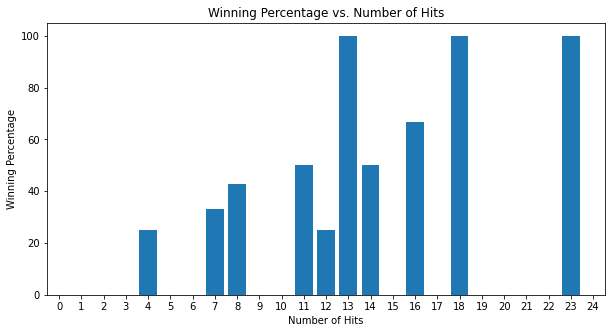

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(hit_win_perc['hits'], hit_win_perc['win_percentage'])
plt.xticks(range(25))
plt.title('Winning Percentage vs. Number of Hits')
plt.xlabel('Number of Hits')
plt.ylabel('Winning Percentage')
plt.show()

####**Logistic Regression Model**

In [ ]:
X = batting_stats['H'].values.reshape(-1,1)
y = batting_stats['W/L'].values.reshape(-1,1)
# Splitting data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 35
Testing Data Count: 16


In [ ]:
# Train Model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
# Test Model: Using model to make predictions
log_prediction = log_model.predict(X_test)
print(log_prediction)
print(log_model.predict_proba(X_test))

[0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0]
[[0.94738477 0.05261523]
 [0.85270899 0.14729101]
 [0.56047401 0.43952599]
 [0.56047401 0.43952599]
 [0.29077861 0.70922139]
 [0.4662652  0.5337348 ]
 [0.4662652  0.5337348 ]
 [0.37440268 0.62559732]
 [0.79863383 0.20136617]
 [0.89418672 0.10581328]
 [0.16137043 0.83862957]
 [0.92501134 0.07498866]
 [0.37440268 0.62559732]
 [0.79863383 0.20136617]
 [0.37440268 0.62559732]
 [0.56047401 0.43952599]]


In [ ]:
# Confusion Matrix and F-score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
conf_matrix = confusion_matrix(y_test, log_prediction)
print(conf_matrix)
print('F-score: ', f1_score(y_test,log_prediction)) # Accuracy of Model
print('Classification report : \n', classification_report(y_test,log_prediction,labels=[1,0]))

[[5 3]
 [4 4]]
F-score:  0.5333333333333333
Classification report : 
               precision    recall  f1-score   support

           1       0.57      0.50      0.53         8
           0       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16



### **5. Probability of Winning if there is >= 1 Homerun (Logistic Regression Model)**

In [ ]:
wins_with_HR = batting_stats[(batting_stats['HR'] != 0) & (batting_stats['W/L'] == 1)].count()['W/L']
games_with_HR = batting_stats[batting_stats['HR'] != 0].count()['W/L']
win_perc_HR = (wins_with_HR / games_with_HR) * 100
print('Winning percentage when team hits HR: ', round(win_perc_HR,2))

wins_wout_HR = batting_stats[(batting_stats['HR'] == 0) & (batting_stats['W/L'] == 1)].count()['W/L']
games_wout_HR = batting_stats[batting_stats['HR'] == 0].count()['W/L']
win_perc_wout_HR = (wins_wout_HR / games_wout_HR) * 100
print("Winning percentage when team doesn't hit HR: ", win_perc_wout_HR)

Winning percentage when team hits HR:  68.42
Winning percentage when team doesn't hit HR:  18.75


####**Logistic Regression Model**

In [ ]:
# Converting HR to binary (0 = no HR, 1 = at least 1 HR)
hr_df = batting_stats.copy()
hr_df['morethan_0_HR'] = hr_df['HR']
hr_df['morethan_0_HR'] = np.where(hr_df['morethan_0_HR'] > 0, 1, hr_df['morethan_0_HR'])


In [ ]:
X = hr_df['morethan_0_HR'].values.reshape(-1,1)
y = hr_df['W/L'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 38
Testing Data Count: 13


In [ ]:
# Train model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
# Test model
log_pred = logreg.predict(X_test)
print(log_pred)
print(log_model.predict_proba(X_test))

In [ ]:
# Confusion Matrix and F-score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
conf_matrix = confusion_matrix(y_test, log_pred)
print(conf_matrix)
print('F-score: ', f1_score(y_test,log_pred)) # Accuracy of Model
print('Classification report : \n', classification_report(y_test,log_pred,labels=[1,0]))